### 1.Import libraries and define coin path

In [67]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import joblib

coin_info = {
    "bitcoin": "outputs/bitcoin_merged_sentiment.csv",
    "ethereum": "outputs/ethereum_merged_sentiment.csv",
    "solana": "outputs/solana_merged_sentiment.csv",
    "cardano": "outputs/cardano_merged_sentiment.csv"
}

### 2.Define function to create lag features

In [77]:
def create_lag_features(df, lags=3):
    for lag in range(1, lags+1):
        df[f'returns_lag{lag}'] = df['returns'].shift(lag)
        df[f'sentiment_lag{lag}'] = df['fear_greed_score'].shift(lag)
    df.dropna(inplace=True)
    return df

### 3.Train Random Forest model

In [78]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

print("\nRandom Forest:")
print("MSE:", mean_squared_error(y_test, rf_preds))
print("MAE:", mean_absolute_error(y_test, rf_preds))
print("R2:", r2_score(y_test, rf_preds))


Random Forest:
MSE: 0.00019008254887910439
MAE: 0.011035540806278481
R2: 0.3673162208225217


### 4.Train XGBoost model

In [79]:
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)

print("\nXGBoost:")
print("MSE:", mean_squared_error(y_test, xgb_preds))
print("MAE:", mean_absolute_error(y_test, xgb_preds))
print("R2:", r2_score(y_test, xgb_preds))



XGBoost:
MSE: 0.0008930801526455227
MAE: 0.014998780172647625
R2: -1.9725891693694697


### 5.Core Function to Train Models and Save Plots



=== BITCOIN ===


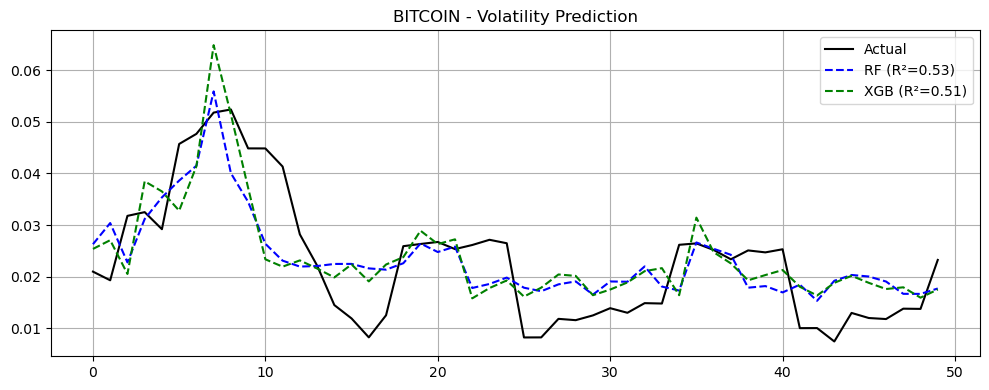

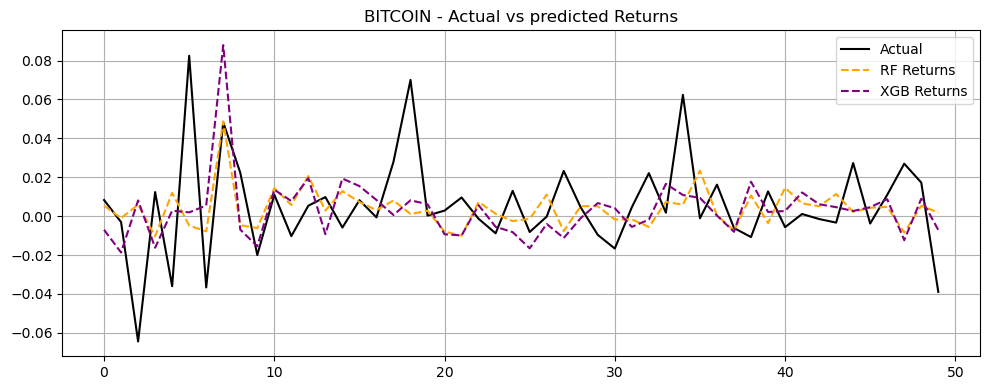



=== ETHEREUM ===


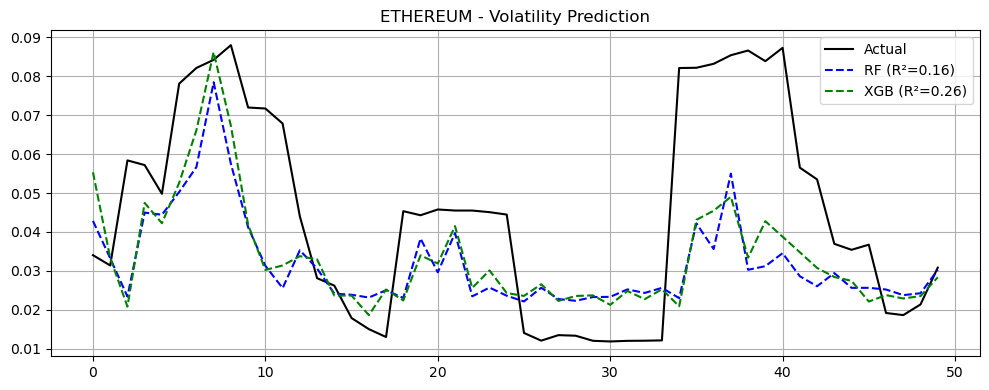

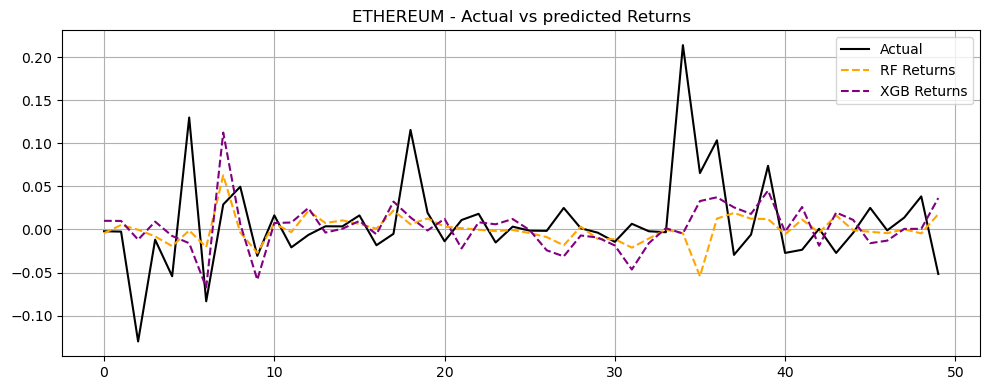



=== SOLANA ===


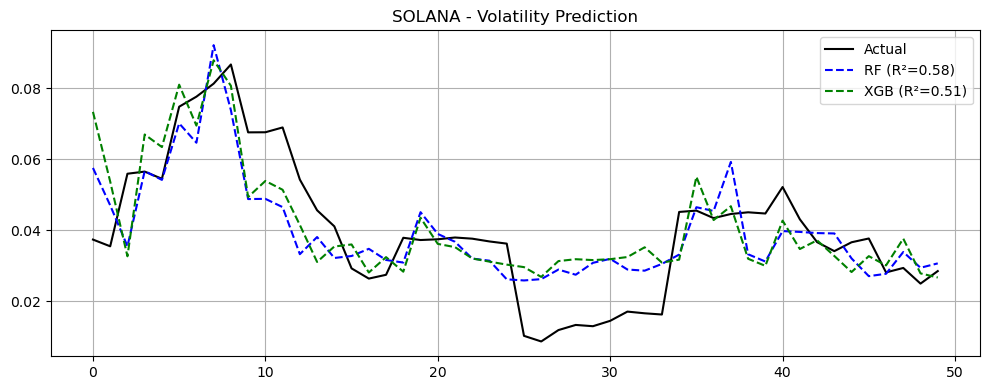

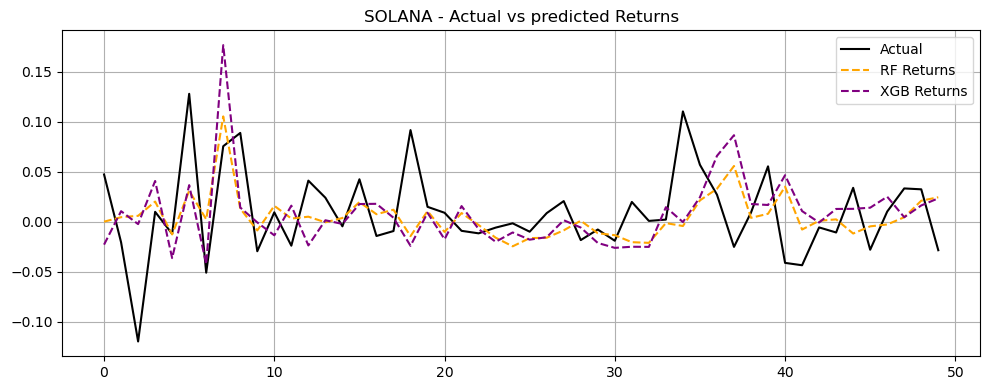



=== CARDANO ===


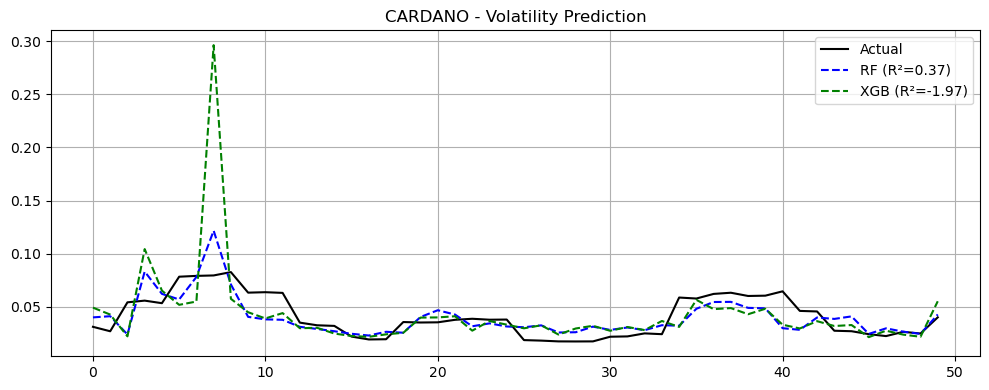

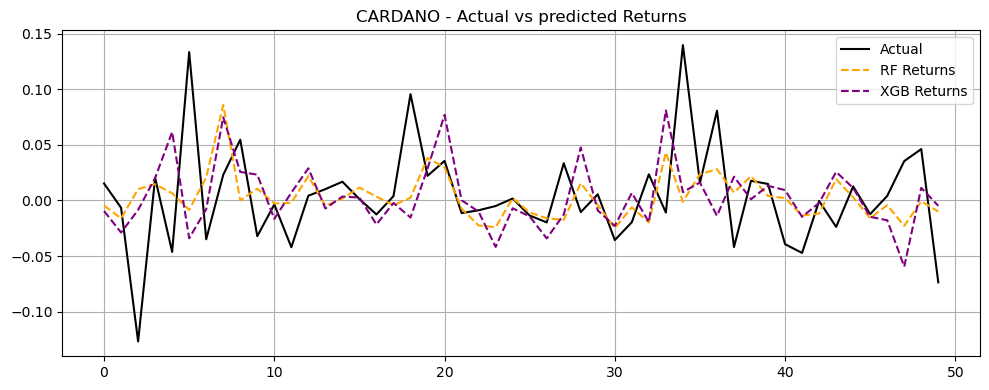

In [ ]:
for coin, path in coin_info.items():
    print(f"\n\n=== {coin.upper()} ===")

    if not os.path.exists(path):
        print(f"File not found for {coin}: {path}")
        continue

    df = pd.read_csv(path)
    df['date'] = pd.to_datetime(df['date'])
    df = create_lag_features(df)

    # Create volatility if not present
    if 'volatility' not in df.columns:
        df['volatility'] = df['returns'].rolling(window=7).std()
        df.dropna(inplace=True)

    # Features & targets
    features = [col for col in df.columns if 'lag' in col]
    X = df[features]
    y_vol = df['volatility']
    y_ret = df['returns']

    # Train/test split
    X_train, X_test, y_vol_train, y_vol_test = train_test_split(X, y_vol, test_size=0.2, shuffle=False)
    _, _, y_ret_train, y_ret_test = train_test_split(X, y_ret, test_size=0.2, shuffle=False)

    # Train models
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_vol_train)
    rf_vol_preds = rf_model.predict(X_test)

    xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
    xgb_model.fit(X_train, y_vol_train)
    xgb_vol_preds = xgb_model.predict(X_test)

    # Volatility Metrics
    rf_r2 = r2_score(y_vol_test, rf_vol_preds)
    xgb_r2 = r2_score(y_vol_test, xgb_vol_preds)

    #Additional model for returns prediction
    rf_ret_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_ret_model.fit(X_train, y_ret_train)
    rf_ret_preds = rf_ret_model.predict(X_test)

    xgb_ret_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
    xgb_ret_model.fit(X_train, y_ret_train)
    xgb_ret_preds = xgb_ret_model.predict(X_test)

    #Plot & Save Volatility
    fig1, ax1 = plt.subplots(figsize=(10, 4))
    ax1.plot(y_vol_test.values[:50], label='Actual', color='black')
    ax1.plot(rf_vol_preds[:50], label=f'RF (R²={rf_r2:.2f})', linestyle='--', color='blue')
    ax1.plot(xgb_vol_preds[:50], label=f'XGB (R²={xgb_r2:.2f})', linestyle='--', color='green')
    ax1.set_title(f"{coin.upper()} - Volatility Prediction")
    ax1.legend()
    ax1.grid(True)
    plt.tight_layout()
    plt.show()
    fig1.savefig(f"../results/{coin}_volatility_pred.png")
    plt.close()

    # Plot & Save Returns
    fig2, ax2 = plt.subplots(figsize=(10, 4))
    ax2.plot(y_ret_test.values[:50], label='Actual', color='black')
    ax2.plot(rf_ret_preds[:50], label='RF Returns', linestyle='--', color='orange')
    ax2.plot(xgb_ret_preds[:50], label='XGB Returns', linestyle='--', color='purple')
    ax2.set_title(f"{coin.upper()} - Actual vs predicted Returns")
    ax2.legend()
    ax2.grid(True)
    plt.tight_layout()
    plt.show()
    fig2.savefig(f"../results/{coin}_returns_pred.png")
    plt.close()

### 6.Save models

In [82]:
# Save models
os.makedirs("../models", exist_ok=True)
joblib.dump(rf_model, f"../models/{coin}_rf_vol_model.pkl")
joblib.dump(xgb_model, f"../models/{coin}_xgb_vol_model.pkl")
joblib.dump(rf_ret_model, f"../models/{coin}_rf_ret_model.pkl")
joblib.dump(xgb_ret_model, f"../models/{coin}_xgb_ret_model.pkl")

['../models/cardano_xgb_ret_model.pkl']